# **NO2 AQ monitoring station data analysis**

In [2]:
import pandas as pd
import xgboost as xg
import numpy as np
import useful_functions
from useful_functions import *
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

Using pandas 1.3.3


 ### Load in EPA data and format it - Source: https://aqs.epa.gov/aqsweb/airdata/download_files.html

In [3]:
# load in AQ data from EPA and format to remove spaces
in_df = pd.read_csv(r'C:\Users\xavie\Documents\data_science_scripts\daily_us_no2_data.csv')

for col in list(in_df.columns):
        if in_df[col].dtypes == object:
            in_df[col].replace(' ', '_', regex=True, inplace=True)
        if ' ' in str(col):
            new = str(col).replace(' ', '_')
            in_df.rename(columns = {str(col):new}, inplace = True)
            

in_df.head()

,State_Code,County_Code,Site_Num,Parameter_Code,POC,Latitude,Longitude,Datum,Parameter_Name,Sample_Duration,...,AQI,Method_Code,Method_Name,Local_Site_Name,Address,State_Name,County_Name,City_Name,CBSA_Name,Date_of_Last_Change
0,1,73,23,42602,1,33.553056,-86.815,WGS84,Nitrogen_dioxide_(NO2),1_HOUR,...,8,200,Teledyne-API_Model_200EUP_or_T200UP_-_Photolyt...,North_Birmingham,"NO._B'HAM,SOU_R.R.,_3009_28TH_ST._NO.",Alabama,Jefferson,Birmingham,"Birmingham-Hoover,_AL",6/12/2020
1,1,73,23,42602,1,33.553056,-86.815,WGS84,Nitrogen_dioxide_(NO2),1_HOUR,...,16,200,Teledyne-API_Model_200EUP_or_T200UP_-_Photolyt...,North_Birmingham,"NO._B'HAM,SOU_R.R.,_3009_28TH_ST._NO.",Alabama,Jefferson,Birmingham,"Birmingham-Hoover,_AL",6/12/2020
2,1,73,23,42602,1,33.553056,-86.815,WGS84,Nitrogen_dioxide_(NO2),1_HOUR,...,12,200,Teledyne-API_Model_200EUP_or_T200UP_-_Photolyt...,North_Birmingham,"NO._B'HAM,SOU_R.R.,_3009_28TH_ST._NO.",Alabama,Jefferson,Birmingham,"Birmingham-Hoover,_AL",6/12/2020
3,1,73,23,42602,1,33.553056,-86.815,WGS84,Nitrogen_dioxide_(NO2),1_HOUR,...,17,200,Teledyne-API_Model_200EUP_or_T200UP_-_Photolyt...,North_Birmingham,"NO._B'HAM,SOU_R.R.,_3009_28TH_ST._NO.",Alabama,Jefferson,Birmingham,"Birmingham-Hoover,_AL",6/12/2020
4,1,73,23,42602,1,33.553056,-86.815,WGS84,Nitrogen_dioxide_(NO2),1_HOUR,...,30,200,Teledyne-API_Model_200EUP_or_T200UP_-_Photolyt...,North_Birmingham,"NO._B'HAM,SOU_R.R.,_3009_28TH_ST._NO.",Alabama,Jefferson,Birmingham,"Birmingham-Hoover,_AL",6/12/2020


In [4]:
# print column names
print('Columns: %s' % in_df.columns)

# find unique methods used for relevant columns
print('Methods used: %s' % in_df.Method_Name.unique())
    
# print total number of sites
print('Monitoring sites: %s' % len(list(in_df.Latitude.unique())))

Columns: Index(['State_Code', 'County_Code', 'Site_Num', 'Parameter_Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter_Name', 'Sample_Duration',
       'Pollutant_Standard', 'Date_Local', 'Units_of_Measure', 'Event_Type',
       'Observation_Count', 'Observation_Percent', 'Arithmetic_Mean',
       '1st_Max_Value', '1st_Max_Hour', 'AQI', 'Method_Code', 'Method_Name',
       'Local_Site_Name', 'Address', 'State_Name', 'County_Name', 'City_Name',
       'CBSA_Name', 'Date_of_Last_Change'],
      dtype='object')
Methods used: ['Teledyne-API_Model_200EUP_or_T200UP_-_Photolytic-Chemiluminescence'
 'Instrumental_-_Chemiluminescence_Thermo_Electron_42C-TL,_42i-TL'
 'INSTRUMENTAL_-_GAS_PHASE_CHEMILUMINESCENCE'
 'INSTRUMENTAL_-_CHEMILUMINESCENCE'
 'Teledyne_Model_T500U_-_Cavity_Attenuated_Phase_Shift_Spectroscopy'
 'Instrumental_-_Chemiluminescence_Teledyne_API_200_EU/501'
 'Instrumental_-_Chemiluminescence'
 'INSTRUMENTAL_-_GAS-PHASE_CHEMILUMINESCENCE'
 'Teledyne-API_Model_T200P_

In [5]:
# drop excess columns
drop_cols = ['Address', 'Sample_Duration', 'Local_Site_Name', 'CBSA_Name', 'County_Code', 'POC', '1st_Max_Value', '1st_Max_Hour', 'AQI', 'Event_Type']
df = in_df.drop(drop_cols, axis=1)
df.rename(columns = {'Arithmetic_Mean':'mean_no2', 'Latitude':'lat', 'Longitude': 'long'}, inplace=True)
df.head()

,State_Code,Site_Num,Parameter_Code,lat,long,Datum,Parameter_Name,Pollutant_Standard,Date_Local,Units_of_Measure,Observation_Count,Observation_Percent,mean_no2,Method_Code,Method_Name,State_Name,County_Name,City_Name,Date_of_Last_Change
0,1,23,42602,33.553056,-86.815,WGS84,Nitrogen_dioxide_(NO2),NO2_1-hour,1/1/2019,Parts_per_billion,21,88,4.314286,200,Teledyne-API_Model_200EUP_or_T200UP_-_Photolyt...,Alabama,Jefferson,Birmingham,6/12/2020
1,1,23,42602,33.553056,-86.815,WGS84,Nitrogen_dioxide_(NO2),NO2_1-hour,1/8/2019,Parts_per_billion,11,46,6.263636,200,Teledyne-API_Model_200EUP_or_T200UP_-_Photolyt...,Alabama,Jefferson,Birmingham,6/12/2020
2,1,23,42602,33.553056,-86.815,WGS84,Nitrogen_dioxide_(NO2),NO2_1-hour,1/9/2019,Parts_per_billion,21,88,4.957143,200,Teledyne-API_Model_200EUP_or_T200UP_-_Photolyt...,Alabama,Jefferson,Birmingham,6/12/2020
3,1,23,42602,33.553056,-86.815,WGS84,Nitrogen_dioxide_(NO2),NO2_1-hour,1/10/2019,Parts_per_billion,24,100,5.891667,200,Teledyne-API_Model_200EUP_or_T200UP_-_Photolyt...,Alabama,Jefferson,Birmingham,6/12/2020
4,1,23,42602,33.553056,-86.815,WGS84,Nitrogen_dioxide_(NO2),NO2_1-hour,1/11/2019,Parts_per_billion,24,100,14.500000,200,Teledyne-API_Model_200EUP_or_T200UP_-_Photolyt...,Alabama,Jefferson,Birmingham,6/12/2020


### Visualize day % observation values and apply quality threshold

Observation percent: mean= 95.63, STD= 9.43
3 STDs less than mean: 67.34
Total observations: 155489


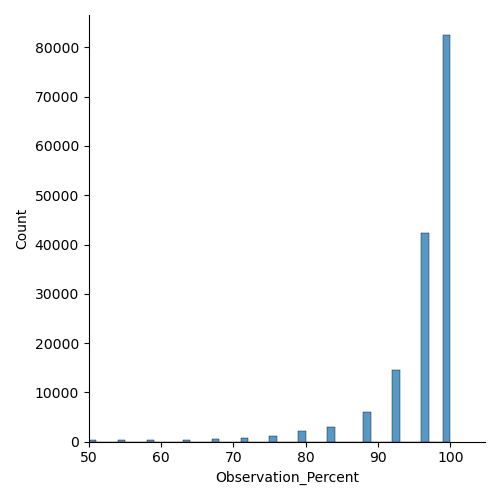

In [6]:
# visualize distribution of observation %, and find decent threshold for inclusion (Keller et al., 2021 used 75%)
%matplotlib widget
plot = sns.displot(data=in_df, x="Observation_Percent", binwidth=1)
plot.set(xlim=(50, None))

# find mean and std of observation %, could roughly -3 STDs be a good cut off
obs_percents = in_df['Observation_Percent'].to_numpy()
mean, std = np.round(np.nanmean(obs_percents),2), np.round(np.nanstd(obs_percents),2)
three_stdless = mean - (3 * std)
print('Observation percent: mean= %s, STD= %s' % (mean, std))
print('3 STDs less than mean: %s' % three_stdless)

# calculate number of rows so we can see how many are removed
row_num = df.shape[0]
print('Total observations: %s' % row_num)

In [7]:
# remove days with not enough observations
thresh = 70
df_v2 = df.loc[df['Observation_Percent'] >= thresh]
row_num2 = df_v2.shape[0]
print('New # of day mean NO2 values: %s' %row_num2)
print('Rows removed by %s percent threshold: %s' % (thresh, row_num - row_num2))

New # of day mean NO2 values: 152301
Rows removed by 70 percent threshold: 3188


## **Visualize NO2 data**

### All observed NO2 concentrations

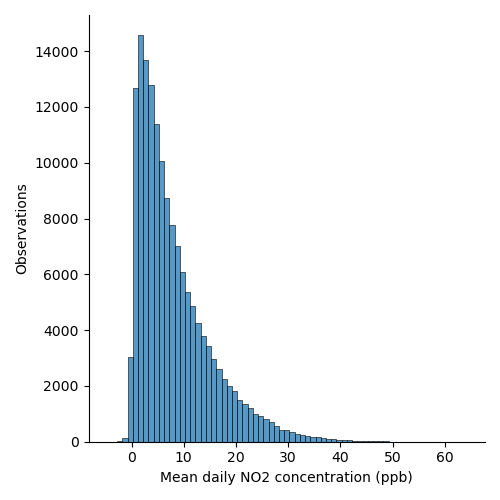

In [8]:
# visualize aq data (all observations)
%matplotlib widget
plot = sns.displot(data=df_v2, x="mean_no2", binwidth=1)
plot.set(xlabel='Mean daily NO2 concentration (ppb)')
plot.set(ylabel='Observations')

### Explore methods and method codes. Plot NO2 stratified by method codes

In [9]:
# make sure method codes and methods are aligned
methods_dict = {}
codes, methods = df_v2.Method_Code.unique(), df_v2.Method_Name.unique()
print('# of methods codes: %s' % len(codes))
print('# of method names: %s' %  len(methods))

assos1 = []
for i, key in enumerate(codes):
    sub = df_v2.loc[df_v2['Method_Code'] == key]
    assos1.append(len(sub.Method_Name.unique()))

    if key == codes[-1]:
        m = np.max(assos1)
        print('The most methods any code is assocaited w/ is %s' % m)
        

assos2 = []
for i, name in enumerate(methods):
    sub = df_v2.loc[df_v2['Method_Name'] == name]
    assos2.append(len(sub.Method_Code.unique()))
    
    if name == methods[-1]:
        m = np.max(assos2)
        print('The most codes any name is assocaited w/ is %s' % m)
        
        if m > 1:
            print(list(zip(assos2, methods)))

# of methods codes: 12
# of method names: 9
The most methods any code is assocaited w/ is 1
The most codes any name is assocaited w/ is 3
[(1, 'Teledyne-API_Model_200EUP_or_T200UP_-_Photolytic-Chemiluminescence'), (1, 'Instrumental_-_Chemiluminescence_Thermo_Electron_42C-TL,_42i-TL'), (1, 'INSTRUMENTAL_-_GAS_PHASE_CHEMILUMINESCENCE'), (3, 'INSTRUMENTAL_-_CHEMILUMINESCENCE'), (1, 'Teledyne_Model_T500U_-_Cavity_Attenuated_Phase_Shift_Spectroscopy'), (1, 'Instrumental_-_Chemiluminescence_Teledyne_API_200_EU/501'), (2, 'Instrumental_-_Chemiluminescence'), (1, 'INSTRUMENTAL_-_GAS-PHASE_CHEMILUMINESCENCE'), (1, 'Teledyne-API_Model_T200P_Chemiluminescence_-_Photolytic-Chemiluminescence')]


[Text(0.5, 0, 'Mean daily NO2 concentration (ppb)')]

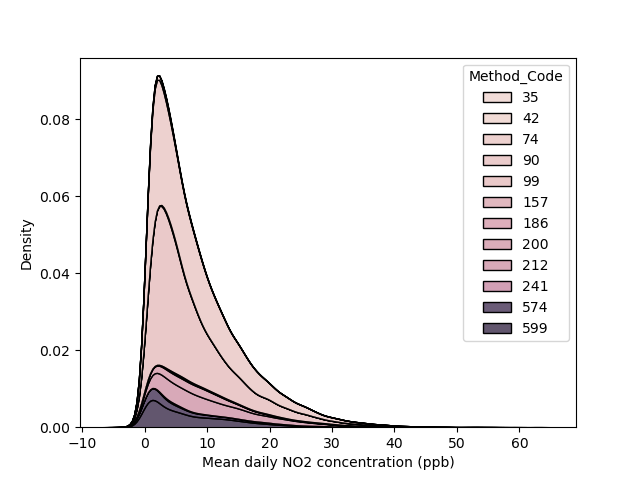

In [10]:
# visualize no2 by method codes
%matplotlib widget
plot = sns.kdeplot(data=df_v2, x="mean_no2", hue='Method_Code', multiple="stack")
sns.set_style()
plot.set(xlabel='Mean daily NO2 concentration (ppb)')

### Create analysis ready dataframe and explore month dependent trends in NO2

In [11]:
# make a dataframe with just pertinent datat and create new month, day of the week, weekend/weekday columns
keep_list = ['lat', 'long', 'State_Name', 'Date_Local', 'mean_no2']
data = df_v2[keep_list]

data['Date_Local'] =  pd.to_datetime(data['Date_Local'])
data['year'] = data['Date_Local'].dt.year
data['month'] = data['Date_Local'].dt.month
data['dayofmonth'] = data['Date_Local'].dt.day
data['dayofyear'] = data['Date_Local'].dt.dayofyear
data['counter'] = 1

# create column coding days as either weekdays or weekends (1=weekend, 0=not weekend)
data['dayname'] = data['Date_Local'].dt.day_name()
data['weekend'] = np.where((data['dayname'] == 'Saturday') | (data['dayname'] == 'Sunday') , 1, 0)
data.drop(['dayname'], axis=1, inplace=True)

# drop Alaska, Hawaii, and Puerto Rico (| is or in pandas)
data.drop(data[(data.State_Name == 'Alaska') | (data.State_Name == 'Hawaii') | (data.State_Name == 'Puerto_Rico')].index, inplace=True)
data.head()

,lat,long,State_Name,Date_Local,mean_no2,year,month,dayofmonth,dayofyear,counter,weekend
0,33.553056,-86.815,Alabama,2019-01-01,4.314286,2019,1,1,1,1,0
2,33.553056,-86.815,Alabama,2019-01-09,4.957143,2019,1,9,9,1,0
3,33.553056,-86.815,Alabama,2019-01-10,5.891667,2019,1,10,10,1,0
4,33.553056,-86.815,Alabama,2019-01-11,14.500000,2019,1,11,11,1,0
5,33.553056,-86.815,Alabama,2019-01-12,7.254167,2019,1,12,12,1,1


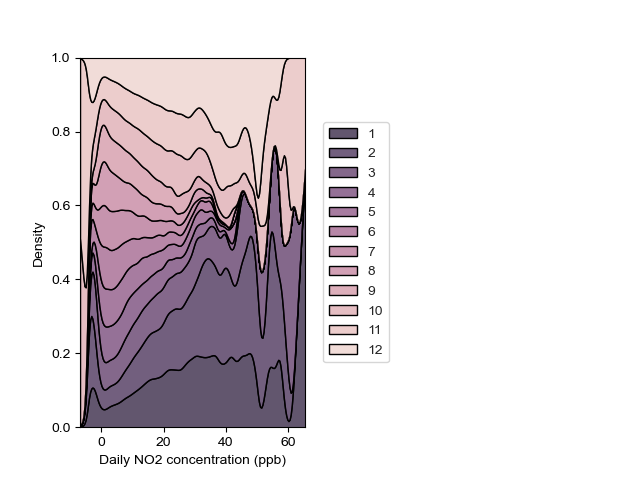

In [12]:
# visualize no2 by month using a filled density plot
%matplotlib widget
plt.subplot(121)
plot = sns.kdeplot(data=data, x="mean_no2", hue='month', multiple="fill", common_norm=False)
sns.set_style()
sns.set_style('white', rc={'axes.facecolor': 'white','patch.edgecolor': 'black','patch.force_edgecolor': True, 'axes.edgecolor': 'black'})
plot.set(xlabel='Daily NO2 concentration (ppb)')
plot.legend(range(1,13), loc='center right', bbox_to_anchor=(1.4,0.5))

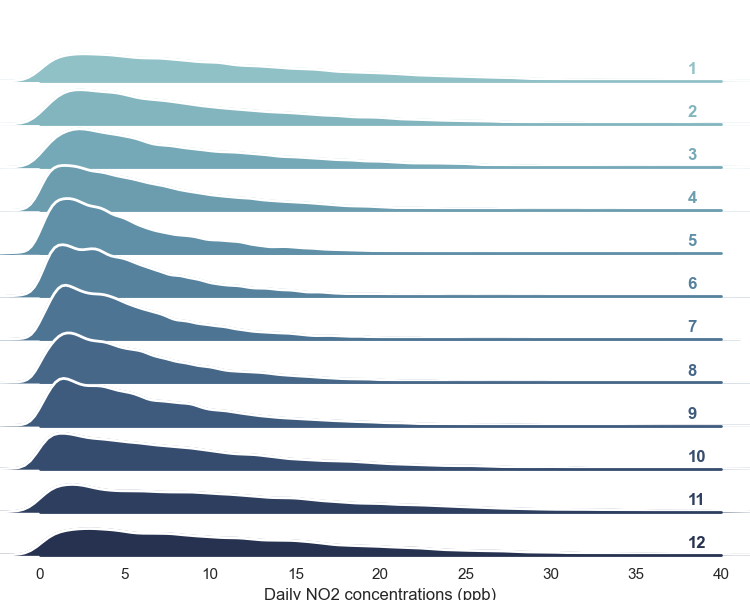

In [13]:
# make pretty denisty plots!
%matplotlib widget
# Initialize the FacetGrid object
sns.set_style()
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(13, rot=-.25, light=.7)
g = sns.FacetGrid(data, row="month", hue="month", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "mean_no2", bw_adjust=.5, clip_on=False,fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "mean_no2", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0.95, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "month")

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(xlabel='Daily NO2 concentrations (ppb)')
g.set(yticks=[], ylabel="")
g.set(xlim=(0, 40))
g.despine(bottom=True, left=True)

## **Verify data quality**

### Check for station daily NO2 observation duplicates and/or incorrect month-day mapping

In [14]:
# check that each month is associated w/ the correct # of days
assos = []
correct = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
for i, m in enumerate(data.month.unique()):
    sub = data.loc[data['month'] == m]
    assos.append(len(sub.dayofyear.unique()))
if assos == correct:
    print('Months/day relationships are correct')
else:
    print('Error! Debug!')

Months/day relationships are correct


In [15]:
# Check for stations w/ duplicate day averaged NO2 values
st_days = data.groupby(['lat', 'long', 'dayofyear']).sum() #group by unique lat/long dayofyear combos
print('Maximum amount of data points per day (if above 1 we need to filter): %s' % st_days['counter'].max())
dups = st_days.loc[st_days['counter'] == 2]

# make a dataframe of only lat/longs with duplicae values
z = dups.groupby(['lat', 'long']).std()
print('# of unique lat/long w/ duplicate day values: %s' % z.shape[0])

# drop duplicates if desired
drop_dups = True
if drop_dups == True:
    data.drop_duplicates(['lat', 'long', 'dayofyear'], keep='first', inplace=True)
    
data.head()

Maximum amount of data points per day (if above 1 we need to filter): 2
# of unique lat/long w/ duplicate day values: 8


,lat,long,State_Name,Date_Local,mean_no2,year,month,dayofmonth,dayofyear,counter,weekend
0,33.553056,-86.815,Alabama,2019-01-01,4.314286,2019,1,1,1,1,0
2,33.553056,-86.815,Alabama,2019-01-09,4.957143,2019,1,9,9,1,0
3,33.553056,-86.815,Alabama,2019-01-10,5.891667,2019,1,10,10,1,0
4,33.553056,-86.815,Alabama,2019-01-11,14.500000,2019,1,11,11,1,0
5,33.553056,-86.815,Alabama,2019-01-12,7.254167,2019,1,12,12,1,1


### Calculate the average amount of days w/ valid data for each month

In [16]:
st_months = data.groupby(['lat', 'long', 'month']).sum()
st_months.reset_index(inplace=True)
st_months.head()

,lat,long,month,mean_no2,year,dayofmonth,dayofyear,counter,weekend
0,25.732878,-80.16175,1,167.002379,58551,461,461,29,8
1,25.732878,-80.16175,2,55.282500,44418,341,1023,22,8
2,25.732878,-80.16175,3,137.195529,60570,477,2247,30,10
3,25.732878,-80.16175,4,70.350480,60570,465,3165,30,8
4,25.732878,-80.16175,5,50.323572,58551,493,3973,29,8


In [17]:
m_list = [] # will store a list for each month that has the # of valid days for all stations

for i, month in enumerate(range(1, 13)):
    sub = st_months.loc[st_months['month'] == month]
    m_list.append(sub['counter'].to_numpy())

# find average monthly coverage and compare to days in the month
for i, month in enumerate(m_list):
    c = correct[i]
    mean = np.nanmean(month)
    std = np.nanstd(month)
    dis = c - mean
    dis_z = dis / std # discrepancy Z score
    print('Mean valid data days for month %s: %s/%s' % (i + 1, mean, c))
    print('Standard deviation for month %s: %s' %  (i + 1, std))
    print('The discrepancy is -%s, and %s standard deviations\n' % (dis, dis_z))

Mean valid data days for month 1: 29.5635103926097/31
Standard deviation for month 1: 4.192400323394821
The discrepancy is -1.4364896073902997, and 0.3426413263481226 standard deviations

Mean valid data days for month 2: 26.702764976958527/28
Standard deviation for month 2: 3.660304148057222
The discrepancy is -1.2972350230414733, and 0.3544063472785468 standard deviations

Mean valid data days for month 3: 29.701149425287355/31
Standard deviation for month 3: 3.57422105501127
The discrepancy is -1.2988505747126453, and 0.36339402480201377 standard deviations

Mean valid data days for month 4: 28.49074074074074/30
Standard deviation for month 4: 3.7761320852662488
The discrepancy is -1.5092592592592595, and 0.3996839160229863 standard deviations

Mean valid data days for month 5: 29.41570438799076/31
Standard deviation for month 5: 3.8974063769237683
The discrepancy is -1.5842956120092389, and 0.4064999794195767 standard deviations

Mean valid data days for month 6: 28.4088785046729/3

### Map NO2 stations

In [18]:
# make a dataframe storing unique latlong pairs for plotting on contigous USA map
stations = data.groupby(['lat', 'long']).sum()
rows = stations.shape[0]
stations['station_id'] = range(0, rows)
stations.rename(columns= {'counter':'obsversations'}, inplace=True)
stations.drop(['month', 'year', 'dayofmonth', 'dayofyear','mean_no2'], axis=1, inplace=True)
stations.reset_index(inplace=True)
stations.head()

,lat,long,obsversations,weekend,station_id
0,25.732878,-80.161750,274,82,0
1,25.785472,-80.284206,327,96,1
2,25.798709,-80.210048,266,80,2
3,26.087567,-80.111152,344,102,3
4,26.132677,-80.169817,335,100,4


In [19]:
# define a function that adds our mapping preferences
def cartography(ax):
    """"Add geographic features (may not work unless on cartopy 0.20.0)"""
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES)
    ax.gridlines(proj, draw_labels=True, alpha=0, linestyle='--')

# of stations: 450


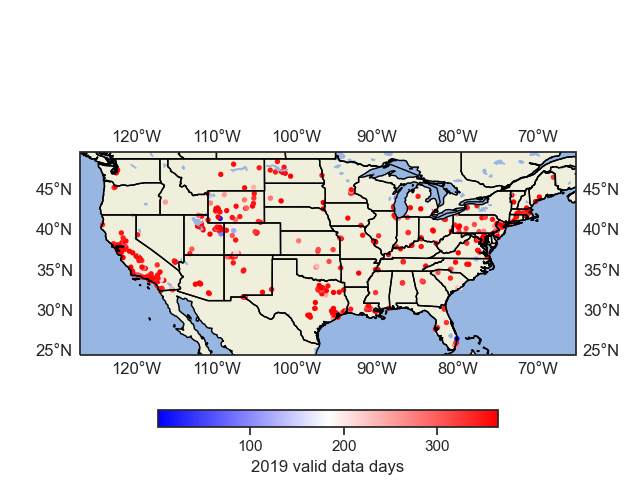

In [20]:
%matplotlib widget
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)

im = ax.scatter(stations['long'], stations['lat'], c=stations['obsversations'], s=8, cmap=cm.bwr)
cartography(ax)

cbar = plt.colorbar(im, location='bottom', label='2019 valid data days', fraction=0.046)
print('# of stations: %s' % stations.shape[0])

### Visualize AQ observations thru time

In [21]:
# store a dataframe for each day in a dictionary
days_dict = {}
labels = []
for day in range(1, 366):
    day_df = data.loc[data['dayofyear'] == day]
    date_format = datetime.strptime(str(2019) + "-" + str(day), "%Y-%j").strftime("%m-%d-%Y")
    days_dict[day] = day_df
    labels.append(date_format)

In [22]:
%matplotlib widget
from mpl_toolkits.axes_grid.inset_locator import inset_axes

# build new animation frames if necessary 
build_new_frames = False
out_folder = r'C:\Users\xavie\Documents\data_science_scripts\animation1'
norm_max = 30

frames = []

if build_new_frames:
    for t in range(1, 366):
        norm = plt.Normalize(vmin=0, vmax=norm_max)
        df = days_dict[t]
        proj = ccrs.PlateCarree()
        fig = plt.gcf()
        fig.bbox_inches='tight'

        ax = plt.axes(projection=proj)
        bounds = [-125.0011, -66.9326, 49.5904, 24.9493]
        im = ax.scatter(df['long'], df['lat'], c=df['mean_no2'], s=8, cmap=cm.bwr, vmin=0, vmax=norm_max)
        ax.set_extent(bounds, crs=ccrs.PlateCarree())
        ax.set_title(labels[t - 1]) # add date to the plot
        cartography(ax)

        axins = inset_axes(ax, width="90%", height="10%", loc='lower center', borderpad=-4)

        cbar = plt.colorbar(im, label='NO2 concentration (ppb)', orientation='horizontal', cax=axins, fraction=0.046, norm=norm)
        cbar.set_ticks(np.arange(0, norm_max + 10, 10))

        out_name = out_folder + '\\frame%s.png' % t

        fig.savefig(out_name)
        frames.append(out_name)
        fig.clear()
        
else:
    for t in range(1, 366):
        out_name = out_folder + '\\frame%s.png' % t
        frames.append(out_name)

In [23]:
%matplotlib widget
import moviepy
from moviepy.editor import ImageSequenceClip, VideoFileClip

build_animation = False
file = out_folder + "\\no2_animation.gif"

if build_animation:
    animation = ImageSequenceClip(frames, fps=20)
    animation.ipython_display(fps=20, loop=True, autoplay=True)
    animation.write_gif(file)

### Make unique monitoring station IDs and print to a XGBoost ready csv

In [54]:
# define output folder
out_folder = r'C:\Users\xavie\Documents\data_science_scripts'

# generate a unique location identifier and make a new column
in_dfs = [data, df_v2]
for df in in_dfs:
    df['locations'] = list(zip(df.lat, df.long))
    locations = df['locations'].unique()
    id_dict = {}
    for i, loc in enumerate(locations):
        sid = i + 1
        id_dict[loc] = sid

    def form(row, id_dict):
        in_tup = (row['lat'], row['long'])
        out = id_dict[in_tup]
        return out

    df['station_id'] = df.apply(lambda row: form(row, id_dict), axis=1)
    print(str(len(df['station_id'].unique())) + ' unique staion Ids created')
    df.drop(['locations'],axis=1, inplace=True)
data.head()

450 unique staion Ids created
455 unique staion Ids created


,lat,long,State_Name,Date_Local,mean_no2,year,month,dayofmonth,dayofyear,counter,weekend,station_id
0,33.553056,-86.815,Alabama,2019-01-01,4.314286,2019,1,1,1,1,0,1
2,33.553056,-86.815,Alabama,2019-01-09,4.957143,2019,1,9,9,1,0,1
3,33.553056,-86.815,Alabama,2019-01-10,5.891667,2019,1,10,10,1,0,1
4,33.553056,-86.815,Alabama,2019-01-11,14.500000,2019,1,11,11,1,0,1
5,33.553056,-86.815,Alabama,2019-01-12,7.254167,2019,1,12,12,1,1,1


In [55]:
data.to_csv(out_folder + '\\clean_no2_daily_2019.csv') # cleaned data, obs% threshold applied, only relevant columns
df_v2.to_csv(out_folder + '\\allcols_no2_daily_2019.csv') # obs% threshold applied, more original columns (i.e., methods)
print('Data saved to csv files in @ %s' % out_folder)

Data saved to csv files in @ C:\Users\xavie\Documents\data_science_scripts
